In [1]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt

In [6]:
# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5), (0.5))
                                            ])

# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="data/MNIST/test", train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root="data/MNIST/train", train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True)




Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:08<00:00, 1.19MB/s]


Extracting data/MNIST/test\MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST/test\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 180kB/s]


Extracting data/MNIST/test\MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST/test\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 815kB/s] 


Extracting data/MNIST/test\MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST/test\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Extracting data/MNIST/test\MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST/test\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 927kB/s] 


Extracting data/MNIST/train\MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST/train\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 192kB/s]


Extracting data/MNIST/train\MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST/train\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.31MB/s]


Extracting data/MNIST/train\MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST/train\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.01MB/s]

Extracting data/MNIST/train\MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST/train\MNIST\raw



In [7]:
def encode_label(j):
    # 5 -> [[0], [0], [0], [0], [0], [1], [0], [0], [0], [0]]
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

def shape_data(data):
    features = [np.reshape(x[0][0].numpy(), (784,1)) for x in data]
    labels = [encode_label(y[1]) for y in data]
    return zip(features, labels)

train = shape_data(train_dataset)
test = shape_data(test_dataset)

In [8]:
train = list(train)
test = list(test)
print('train imgs -', len(train))
print('test imgs -', len(test))

train imgs - 60000
test imgs - 10000


In [9]:
def average_digit(data, digit):
    filtered_data = [x[0] for x in data if np.argmax(x[1]) == digit]
    filtered_array = np.asarray(filtered_data)
    return np.average(filtered_array, axis=0)

In [10]:
class MyClassifier:
    def __init__(self, W, norm, b = 0.0):
        self.W = W
        self.b = b
        self.norm = norm
    
    def predict(self, x):
        x_norm = np.linalg.norm(x)
        if x_norm == 0:
            return 0.0
        cos_sim = (np.dot(self.W, x)[0][0] / (self.norm * x_norm)) + self.b
        return 1.0 if cos_sim >= 0 else 0.0

In [11]:
avgs = {i: average_digit(train, i) for i in range(10)}
weights = {i: np.transpose(avgs[i]) for i in range(10)} 
norms = {i: np.linalg.norm(weights[i]) for i in range(10)}

In [12]:
accuracies = []
for i in range(10):
    model = MyClassifier(weights[i], norms[i], b=-30)  
    TP, TN, FP, FN = 0, 0, 0, 0
    for digit, label_onehot in test:
        label = np.argmax(label_onehot)
        prediction = model.predict(digit)
        if label == i:
            if prediction == 1:
                TP += 1
            else:
                FN += 1 
        else:
            if prediction == 0:
                TN += 1
            else:
                FP += 1
    acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    accuracies.append(acc)

accuracies

[0.902, 0.8865, 0.8968, 0.899, 0.9018, 0.9108, 0.9042, 0.8972, 0.9026, 0.8991]

In [13]:
class DigitsClassifier:
    def __init__(self, weights, norms, accuracies, b=-0.05):
        self.classifiers = [MyClassifier(weights[i], norms[i], b) for i in range(10)]  
        self.accuracies = accuracies
    
    def predict(self, x):
        
        predictions = [self.accuracies[i] * c.predict(x) for i, c in enumerate(self.classifiers)]
        if max(predictions) == 0:  
            raw_sims = [np.dot(weights[i], x)[0][0] / (norms[i] * np.linalg.norm(x)) for i in range(10)]
            max_idx = np.argmax(raw_sims)
        else:
            max_idx = np.argmax(predictions)
        answer = np.zeros((10, 1))
        answer[max_idx] = 1
        return answer


In [14]:
classifier = DigitsClassifier(weights, norms, accuracies, b = -30)

per_class = []
for target_class in range(10):
    TP = FP = FN = TN = 0
    for digit, label_onehot in test:
        true_label = np.argmax(label_onehot)
        pred_onehot = classifier.predict(digit)
        pred_label = np.argmax(pred_onehot)
        
        if true_label == target_class:
            if pred_label == target_class:
                TP += 1
            else:
                FN += 1
        else:
            if pred_label == target_class:
                FP += 1
            else:
                TN += 1
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    per_class.append((precision, recall))


precisions, recalls = zip(*per_class)
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

Macro Precision: 0.8232
Macro Recall: 0.8185


c:\anac\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


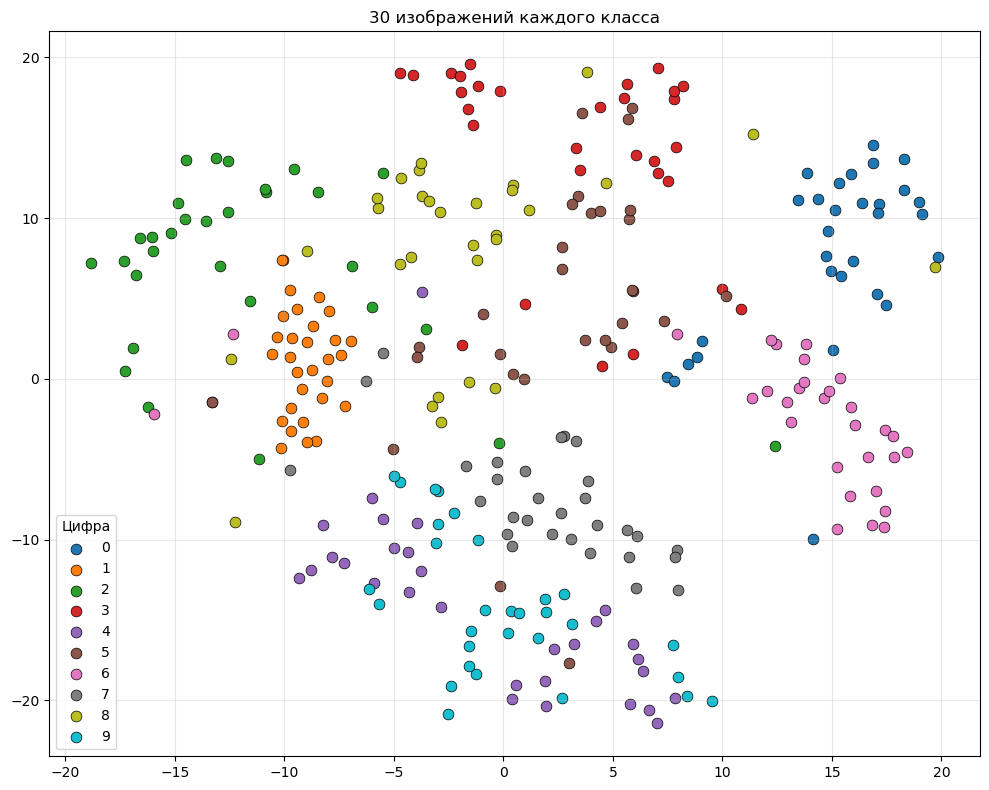

t-SNE: логиты модели 10 → 2D ...


c:\anac\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


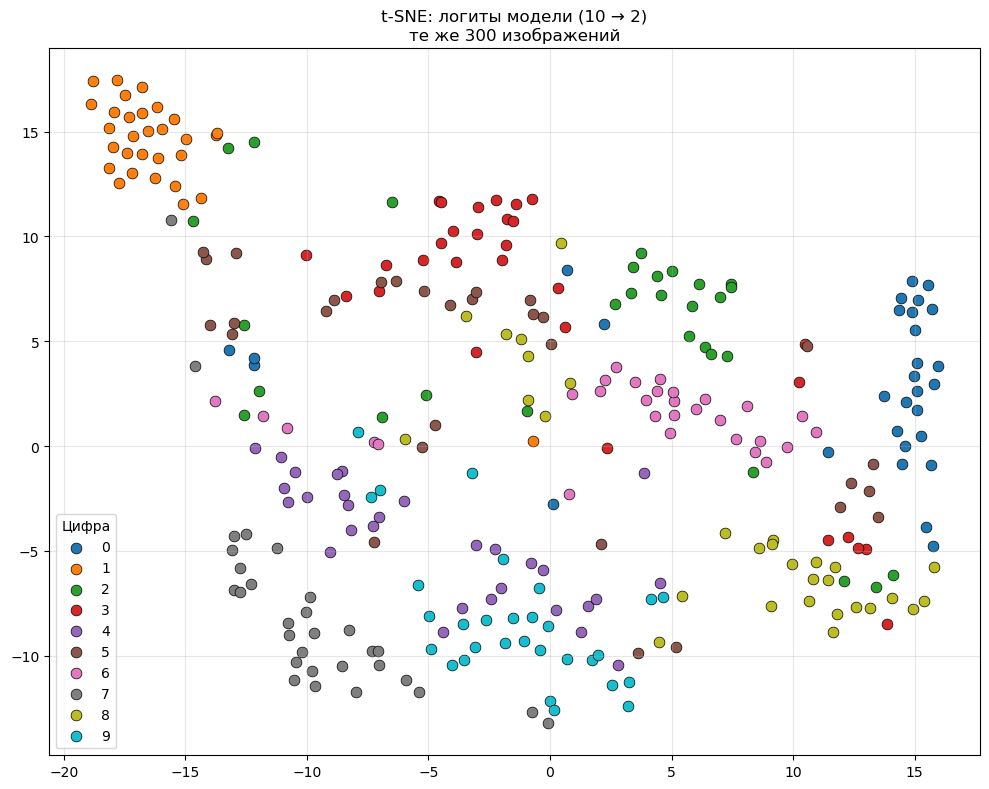

In [15]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)

selected_vectors = []
selected_labels = []

for digit in range(10):

    indices = [idx for idx, (vec, onehot) in enumerate(train) if np.argmax(onehot) == digit]
    chosen = random.sample(indices, 30)                     
    for idx in chosen:
        selected_vectors.append(train[idx][0].flatten())    
        selected_labels.append(digit)

X_784 = np.array(selected_vectors)      
y_labels = np.array(selected_labels)    


tsne_raw = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_2d_raw = tsne_raw.fit_transform(X_784)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for d in range(10):
    mask = y_labels == d
    plt.scatter(X_2d_raw[mask, 0], X_2d_raw[mask, 1],
                c=[colors[d]], label=str(d), s=60, edgecolor='k', linewidth=0.5)
plt.title("30 изображений каждого класса")
plt.legend(title="Цифра")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


logits_10d = []
for vec in selected_vectors:
    vec = vec.reshape(784, 1)                
    pred_onehot = classifier.predict(vec)    # (10,1)
    
    raw_sims = np.array([np.dot(weights[i], vec)[0][0] / (norms[i] * np.linalg.norm(vec) + 1e-8)
                         for i in range(10)])
    logits_10d.append(raw_sims)

X_10d = np.array(logits_10d)                  # (300, 10)


print("t-SNE: логиты модели 10 → 2D ...")
tsne_logits = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_2d_logits = tsne_logits.fit_transform(X_10d)

plt.figure(figsize=(10, 8))
for d in range(10):
    mask = y_labels == d
    plt.scatter(X_2d_logits[mask, 0], X_2d_logits[mask, 1],
                c=[colors[d]], label=str(d), s=60, edgecolor='k', linewidth=0.5)
plt.title("t-SNE: логиты модели (10 → 2)\nте же 300 изображений")
plt.legend(title="Цифра")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
